In [1]:
import os, random, copy
import cv2, torch, shutil, time
from collections import namedtuple

import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import models

from sklearn import manifold
from sklearn import decomposition
import torch.utils.data as torchdata
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Set original data path
data_path = "./Elevators_Dataset/elevators_dataset"

In [4]:
# Set directory for 
data_dir = "./"
image_dir = os.path.join(data_dir, "images")
train_dir = os.path.join(image_dir, "train")
test_dir  = os.path.join(image_dir, "test")

os.makedirs(image_dir, exist_ok=True)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [5]:
# define two classes related to target predictions
classes = ["open", "closed"]
for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)
    
phases = ["train", "test"]
for phase in phases:
    for img_name in os.listdir(os.path.join(data_path, phase)):
        if img_name.endswith("open.jpg"):
            img_src = os.path.join(data_path, phase, img_name)
            img_dst = os.path.join(image_dir, phase, "open", img_name)
            shutil.copyfile(img_src, img_dst)
        elif img_name.endswith("closed.jpg"):
            img_src = os.path.join(data_path, phase, img_name)
            img_dst = os.path.join(image_dir, phase, "closed", img_name)
        shutil.copyfile(img_src, img_dst)

In [6]:
# Calculate the mean and std of the dataset
data = datasets.ImageFolder(root=train_dir, transform=transforms.ToTensor())

mean, std = torch.zeros(3), torch.zeros(3)
for img, label in data:
    mean += torch.mean(img, dim=(1, 2))
    std  += torch.std(img, dim=(1, 2))
    
mean /= len(data)
std /= len(data)

In [7]:
# Set up data params
pretrained_size = 224
data_mean = mean
data_std = std

train_transforms = transforms.Compose([
                        transforms.Resize(pretrained_size),
                        transforms.RandomRotation(5),
                        transforms.RandomHorizontalFlip(0.5),
                        transforms.RandomCrop(pretrained_size, padding=10),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=data_mean, std=data_std)
                    ])

test_transforms = transforms.Compose([
                        transforms.Resize(pretrained_size),
                        transforms.CenterCrop(pretrained_size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=data_mean, std=data_std)
                    ])

In [8]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data  = datasets.ImageFolder(root=test_dir, transform=test_transforms)

In [9]:
# Split train and val
SPLIT_RATIO = 0.8 # 80% for training, 20% for valid
n_training_samples = int(len(train_data) * SPLIT_RATIO)
n_valid_samples = len(train_data) - n_training_samples

train_data, valid_data = torchdata.random_split(train_data, [n_training_samples, n_valid_samples])

# Change transform in valid dataset
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [10]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of valid samples: {len(valid_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 131
Number of valid samples: 33
Number of test samples: 18


In [11]:
# Create dataloader
BATCH_SIZE = 8
train_loader = torchdata.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader   = torchdata.DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE)
test_loader  = torchdata.DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [13]:
def plot_images(images, labels, classes, normalize=True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize=(12, 12))
    
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize: image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

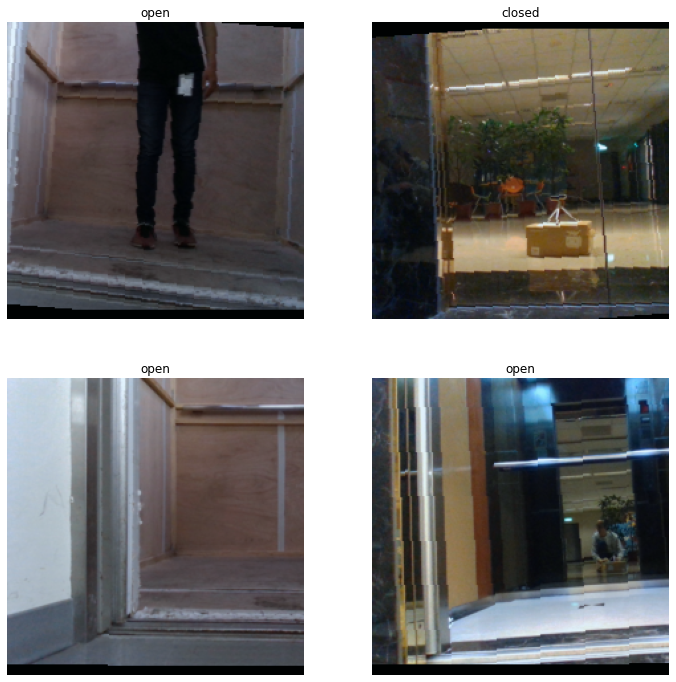

In [14]:
N_IMAGES = 4
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

In [15]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x
    
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x
    
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [16]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2, 2, 2, 2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [17]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up model
pretrained_model = models.resnet50(pretrained=True) # TODO: change to ResNet-34, 50, 101, 152
features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(features, len(classes))

model = ResNet(resnet50_config, len(classes))
model.load_state_dict(pretrained_model.state_dict())

# Send to device
model = model.to(device)

# Set up loss
criterion = nn.CrossEntropyLoss()

# Set optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Set learning scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


In [19]:
def train(model, dataloader, optimizer, criterion, scheduler, device):
    total = 0
    epoch_loss, epoch_acc = 0, 0
    model.train()
    for i, (images, labels) in tqdm(enumerate(dataloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        total += labels.size(0)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += torch.sum(preds==labels.data).item()
        
    epoch_loss /= total
    epoch_acc /= total
    
    return epoch_loss, epoch_acc

def evaluate(model, criterion, device, phase='test'):
    total = 0
    epoch_loss, epoch_acc = 0, 0
    model.eval()
    if phase == "test":
        dataloader = test_loader
    elif phase == "val":
        dataloader = val_loader
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            
            total += labels.size(0)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            epoch_loss += loss.item()
            epoch_acc += torch.sum(preds==labels.data).item()
            
    epoch_loss /= total
    epoch_acc /= total
    
    return epoch_loss, epoch_acc

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

In [21]:
# Training and validation
TRAINING_EPOCHS = 20
best_acc = 0
best_loss = float('inf')

for epoch in range(TRAINING_EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, exp_lr_scheduler, device)
    valid_loss, valid_acc = evaluate(model, criterion, device, phase='val')
    
#     if valid_acc > best_acc:
#         best_acc = valid_acc
#         torch.save(model.state_dict(), 'classified-model.pth')

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'classified-model.pth')
        
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f"Epoch {epoch+1:03} | Epoch time: {epoch_mins}m {epoch_secs}s")
    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}")
    print(f"Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}")

17it [00:05,  3.03it/s]
5it [00:01,  4.82it/s]


Epoch 001 | Epoch time: 0m 7s
Train Loss: 0.059 | Train Acc:  82.44
Valid Loss: 1554.233 | Valid Acc:  48.48


17it [00:05,  3.30it/s]
5it [00:01,  4.70it/s]


Epoch 002 | Epoch time: 0m 6s
Train Loss: 0.056 | Train Acc:  88.55
Valid Loss: 0.212 | Valid Acc:  75.76


17it [00:05,  3.34it/s]
5it [00:01,  4.69it/s]


Epoch 003 | Epoch time: 0m 6s
Train Loss: 0.039 | Train Acc:  90.84
Valid Loss: 0.131 | Valid Acc:  87.88


17it [00:05,  3.34it/s]
5it [00:01,  4.75it/s]


Epoch 004 | Epoch time: 0m 6s
Train Loss: 0.013 | Train Acc:  96.18
Valid Loss: 0.009 | Valid Acc: 100.00


17it [00:04,  3.41it/s]
5it [00:01,  4.93it/s]


Epoch 005 | Epoch time: 0m 5s
Train Loss: 0.024 | Train Acc:  94.66
Valid Loss: 0.789 | Valid Acc:  72.73


17it [00:04,  3.47it/s]
5it [00:01,  4.76it/s]


Epoch 006 | Epoch time: 0m 5s
Train Loss: 0.023 | Train Acc:  91.60
Valid Loss: 0.122 | Valid Acc:  87.88


17it [00:05,  3.27it/s]
5it [00:01,  4.69it/s]


Epoch 007 | Epoch time: 0m 6s
Train Loss: 0.015 | Train Acc:  97.71
Valid Loss: 0.005 | Valid Acc: 100.00


17it [00:05,  3.26it/s]
5it [00:01,  4.65it/s]


Epoch 008 | Epoch time: 0m 6s
Train Loss: 0.016 | Train Acc:  96.18
Valid Loss: 0.009 | Valid Acc:  93.94


17it [00:05,  3.26it/s]
5it [00:01,  4.70it/s]


Epoch 009 | Epoch time: 0m 6s
Train Loss: 0.062 | Train Acc:  91.60
Valid Loss: 0.009 | Valid Acc: 100.00


17it [00:05,  3.32it/s]
5it [00:01,  4.75it/s]


Epoch 010 | Epoch time: 0m 6s
Train Loss: 0.026 | Train Acc:  93.89
Valid Loss: 0.008 | Valid Acc: 100.00


17it [00:05,  3.38it/s]
5it [00:01,  4.92it/s]


Epoch 011 | Epoch time: 0m 6s
Train Loss: 0.023 | Train Acc:  92.37
Valid Loss: 0.001 | Valid Acc: 100.00


17it [00:05,  3.33it/s]
5it [00:01,  4.81it/s]


Epoch 012 | Epoch time: 0m 6s
Train Loss: 0.011 | Train Acc:  96.18
Valid Loss: 0.007 | Valid Acc:  96.97


17it [00:05,  3.30it/s]
5it [00:01,  4.68it/s]


Epoch 013 | Epoch time: 0m 6s
Train Loss: 0.009 | Train Acc:  97.71
Valid Loss: 0.003 | Valid Acc: 100.00


17it [00:05,  3.25it/s]
5it [00:01,  4.64it/s]


Epoch 014 | Epoch time: 0m 6s
Train Loss: 0.006 | Train Acc:  99.24
Valid Loss: 0.003 | Valid Acc: 100.00


17it [00:05,  3.24it/s]
5it [00:01,  4.61it/s]


Epoch 015 | Epoch time: 0m 6s
Train Loss: 0.007 | Train Acc:  98.47
Valid Loss: 0.001 | Valid Acc: 100.00


17it [00:05,  3.25it/s]
5it [00:01,  4.52it/s]


Epoch 016 | Epoch time: 0m 6s
Train Loss: 0.009 | Train Acc:  98.47
Valid Loss: 0.000 | Valid Acc: 100.00


17it [00:05,  3.26it/s]
5it [00:01,  4.70it/s]


Epoch 017 | Epoch time: 0m 6s
Train Loss: 0.001 | Train Acc: 100.00
Valid Loss: 0.000 | Valid Acc: 100.00


17it [00:05,  3.23it/s]
5it [00:01,  4.64it/s]


Epoch 018 | Epoch time: 0m 6s
Train Loss: 0.004 | Train Acc:  99.24
Valid Loss: 0.000 | Valid Acc: 100.00


17it [00:05,  3.24it/s]
5it [00:01,  4.64it/s]


Epoch 019 | Epoch time: 0m 6s
Train Loss: 0.037 | Train Acc:  98.47
Valid Loss: 0.000 | Valid Acc: 100.00


17it [00:05,  3.26it/s]
5it [00:01,  4.64it/s]

Epoch 020 | Epoch time: 0m 6s
Train Loss: 0.029 | Train Acc:  93.89
Valid Loss: 0.008 | Valid Acc:  96.97


In [22]:
# Validate the test dataset
model.load_state_dict(torch.load('classified-model.pth'))
test_loss, test_acc = evaluate(model, criterion, device, phase='test')
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}")

3it [00:00,  4.97it/s]

Test Loss: 0.003 | Test Acc: 100.00


In [23]:
def get_predictions(model, dataloader):

    model.eval()

    images_list = []
    labels_list = []
    probs = []

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader)):

            images = images.to(device)

            y_pred = model(images)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images_list.append(images.cpu())
            labels_list.append(labels.cpu())
            probs.append(y_prob.cpu())

    images_list = torch.cat(images_list, dim = 0)
    labels_list = torch.cat(labels_list, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images_list, labels_list, probs

In [24]:
images, labels, probs = get_predictions(model, test_loader)

3it [00:00,  4.99it/s]


In [25]:
pred_labels = torch.argmax(probs, 1)

In [26]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (8, 8));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)

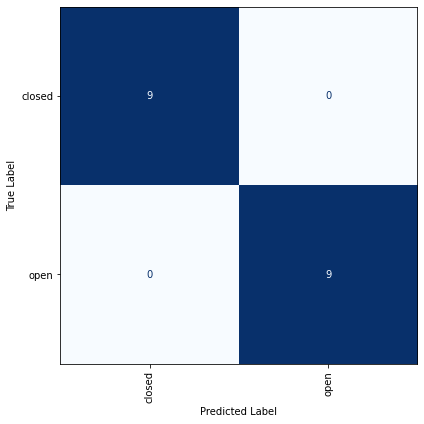

In [27]:
plot_confusion_matrix(labels, pred_labels, classes)

In [28]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [29]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (12, 8))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

IndexError: list index out of range

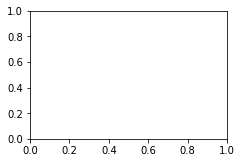

In [30]:
N_IMAGES = 10

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [31]:
def get_representations(model, dataloader):
    model.eval()
    outputs_list = []
    labels_list = []
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader)):
            images = images.to(device)
            y_pred = model(images)
            outputs_list.append(y_pred.cpu())
            labels_list.append(labels)
        
    outputs_list = torch.cat(outputs_list, dim=0)
    labels_list = torch.cat(labels_list, dim=0)

    return outputs_list, labels_list

In [32]:
outputs, labels = get_representations(model, train_loader)

17it [00:04,  3.89it/s]


In [33]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='cividis')
    #handles, _ = scatter.legend_elements(num = None)
    #legend = plt.legend(handles = handles, labels = classes)

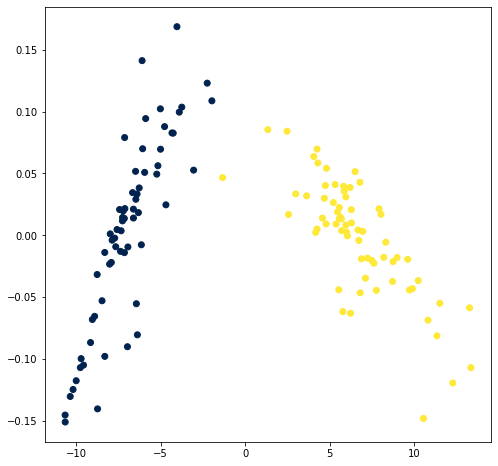

In [34]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [35]:
def get_tsne(data, n_components=2, n_images=None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

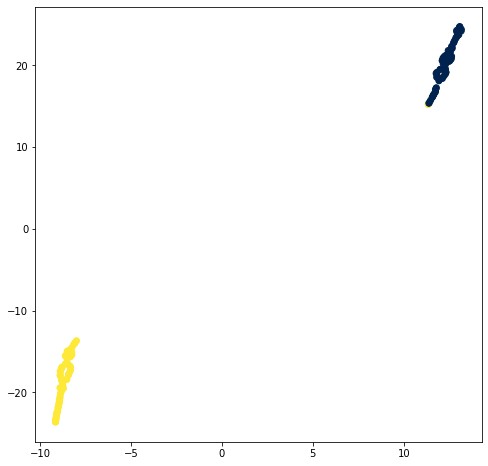

In [36]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

In [37]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)


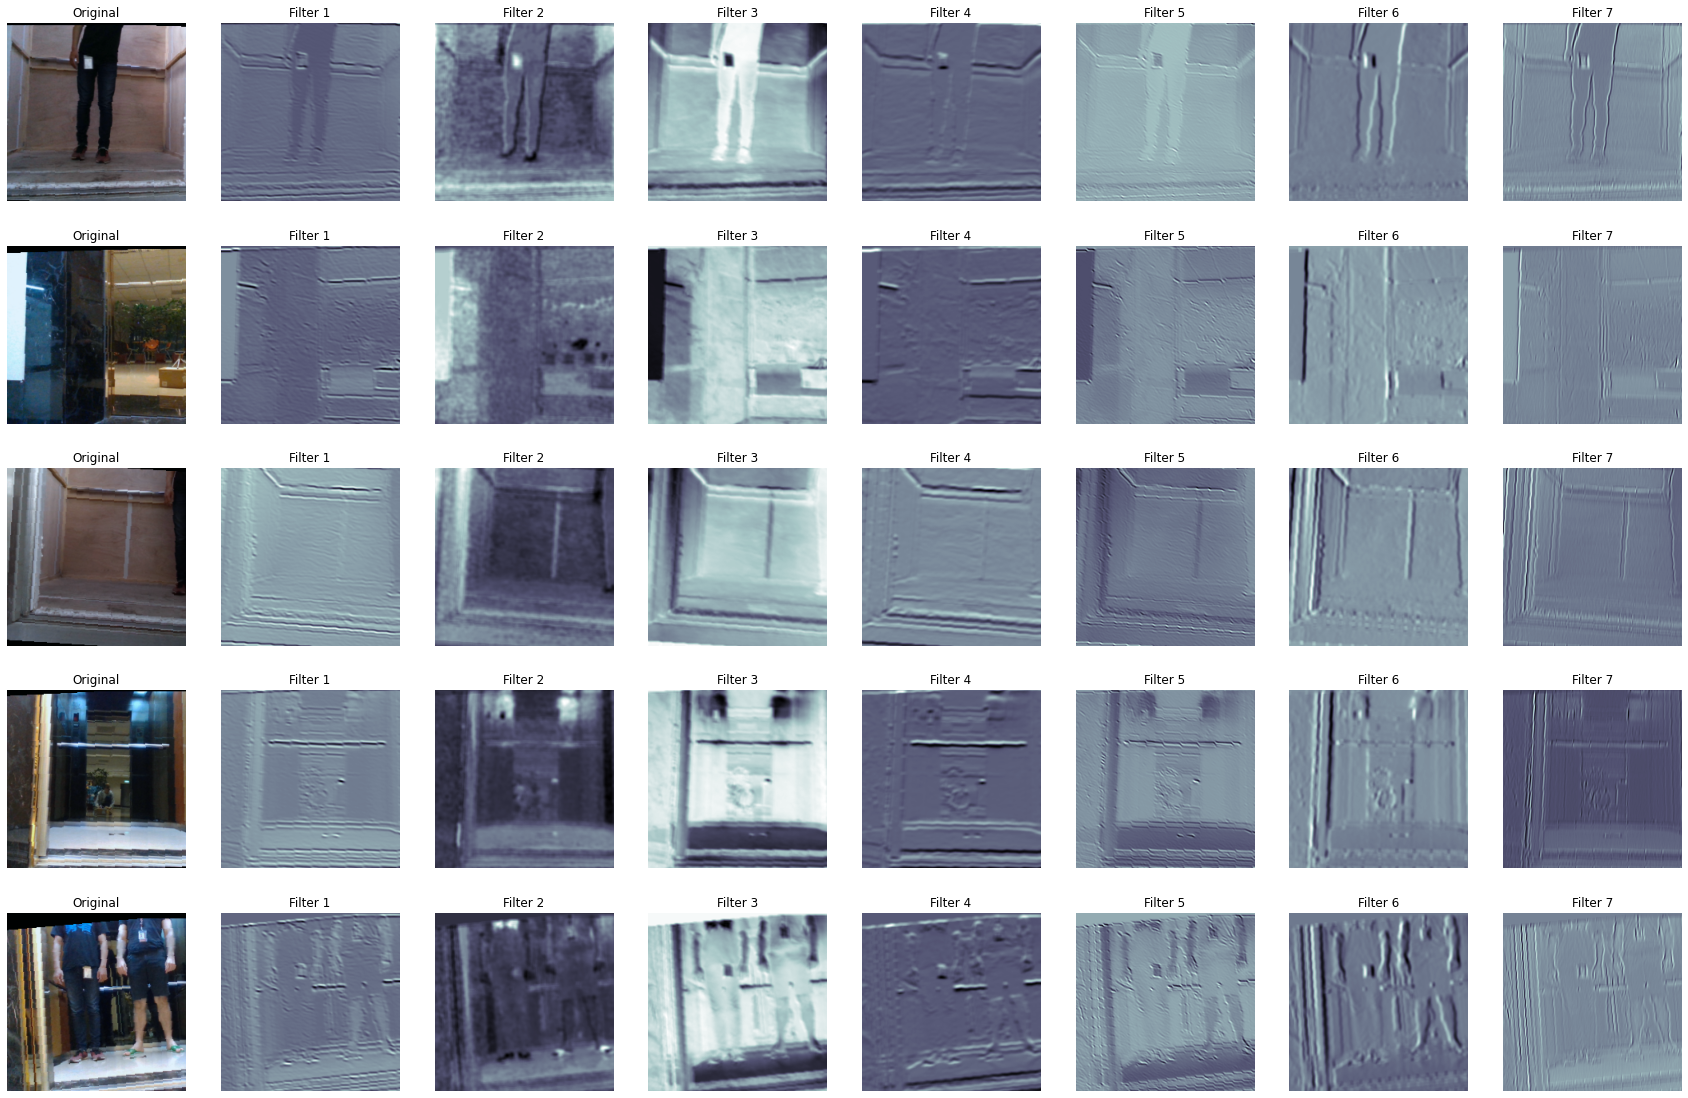

In [38]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [39]:
def plot_filters(filters, normalize=True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

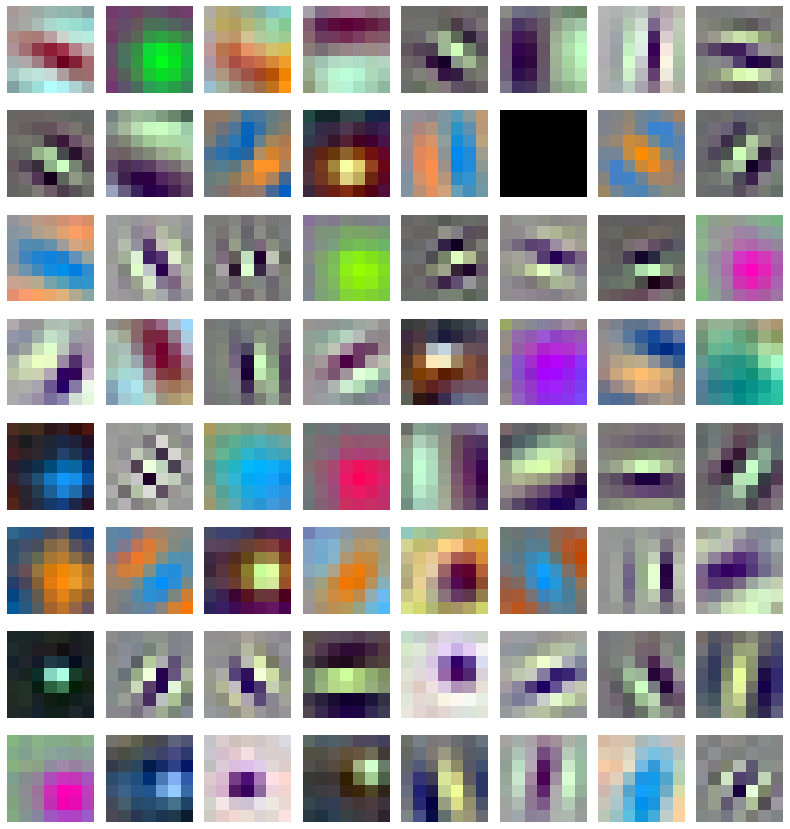

In [40]:
plot_filters(filters)